## Managed Funds - TA Review

#### FINM 36700 - Fall 2025
#### Brian Wickman

### Motivation

Underperformance of active fund managers relative to passive benchmarks is well-documented in academic literature (Jensen (1968), Carhart (1997)). This review covers key concepts related to evaluating the performance of managed funds, measuring associated risks, and understanding manager incentives.

**On Persistence in Mutual Fund Performance** by Mark Carhart (1997) might be Dimensional Fund Advisor's favorite paper. He finds- after accounting for survivorship bias- a four-factor model (market, size, value, momentum) almost completely explains the variation in mutual funds' mean and risk-adjusted returns (exposure to risk, random luck). The only significant persistence is by the worst-return performers, suggesting that poor performance is more persistent than good performance (hence Mark talks about avoiding disaster). **Hot-hands funds infrequently repeat their abnormal performance.** If mutual fund managers had persistent skill, we would expect the same funds to consistently beat the market year after year... Note that we are only talking about lack of persistent success of mutual/ hedge funds (active managers) here; we are **not** commenting on firms that make money by supplying financial services (banks, market makers, or even HFT firms).

**Formula 1 Racing:** Not a big fan of Formula 1 racing and I really question the importance of driver skill; I would think the results are prone to randomness. However, persistence does appear: the same individuals (Lewis Hamilton, Max Verstappen) dominate year after year, suggesting that driver skill does matter.

**Persistent success as a sign of skill (necessary but not sufficient condition).** However, some managers will appear to have skill because they’ve outperformed for several years. But statistically, many of those streaks are inevitable outcomes of chance when you start with a large pool. Consider this example:

At the start of the football season (16 games), you start with an email list consisting of $2^{16} \approx 65000$ recipients:
   - Game 1
        - Randomly split the list:
        - 32,768 people receive “Team A will win.” and 32,768 people receive “Team B will win.”
        - After the game, discard the half who received the incorrect prediction.
        - You now have 32,768 recipients who saw a correct prediction.
   - Game 2
        - Split the remaining 32,768:
        - Half get “Team A will win.”
        - Half get “Team B will win.”
        - After the game, discard the incorrect half.
        - You now have 16,384 recipients who’ve seen two correct predictions.
   - Repeat This Process for All 16 Games
        - Each round, split the remaining recipients in half and send opposing predictions.
        - After each game, keep only the half who received the correct prediction.

At the end of the season, only 1 person remains — someone who has received 16 consecutive correct predictions and thinks that you are a genius. However, this is pure chance, like having ten heads in a row in a sequence of 10000 coin flips; does not mean we have coin flipping skill.

In [ ]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import beta
from IPython.display import Image, display
import helper_functions as pmh

import warnings
warnings.filterwarnings('ignore')

## 1. Measuring Performance

**Imagine we are LPs at a university endowment and are choosing which hedge funds to invest in.** We are faced with conflicting objectives:
1. To identify funds that generate high risk-adjusted returns
2. To be among the first investors in said funds. Among the plethora of benefits:
    - Lower fees (instead of the typical 2/20 fee structure, we might get 1/15)
    - Access to top-performing funds before capacity constraints (think LTCM, merger arbitrage strats have limited capacity)
    - Clout (self-fulfilling prophecy, if we invest, others will follow)
        - Marc Andreesen invested in Facebook, Twitter, Airbnb, Lyft, Instagram, etc. then went on to found Andreessen Horowitz
        - Peter Thiel as first outside investor in Facebook, also backed / started PayPal, Palantir, SpaceX, etc.

**We are incentivized to make statistical inference with small sample sizes.**

****

### 1a. Statistical Uncertainty of Returns

We discuss two issues of statistical uncertainty in this section:
1. **Sample Size:** How large should our sample be to make inferences about the true mean return?
2. **Survivorship bias:** How to account for the 20% of hedge funds that die every year.

(1) We start with **sample size**. We observe a fund with annualized returns satisfying the following (follows in-class example):
- independent, identically distributed (iid)
- volatility $\sigma_r = 15\%$
- sample average $\hat{r} = 10\%$
- sample of length $T = 5$ years

We want to make inferences about the population mean (true mean) return $r$. Using the central limit theorem (CLT), we know that the sampling distribution of the sample mean is approximately normal (note we did not assume normal returns!).) with mean $r$ and standard error (SE) $\sigma_r / \sqrt{T}$. **The standard error of the mean tells how much the sample mean $\hat{r}$ is expected to vary from sample to sample.** The following graph shows that we can only (barely) reject the null hypothesis that the true mean return is 0% at the 5% significance level (two-tailed test) after **10 years of data**.

$$\sigma_{\hat{r}} = \frac{\sigma_r}{\sqrt{T}} = \frac{15\%}{\sqrt{10}} = 4.74\% \implies \quad t = \frac{10\%}{4.74\%} \approx 2.11$$

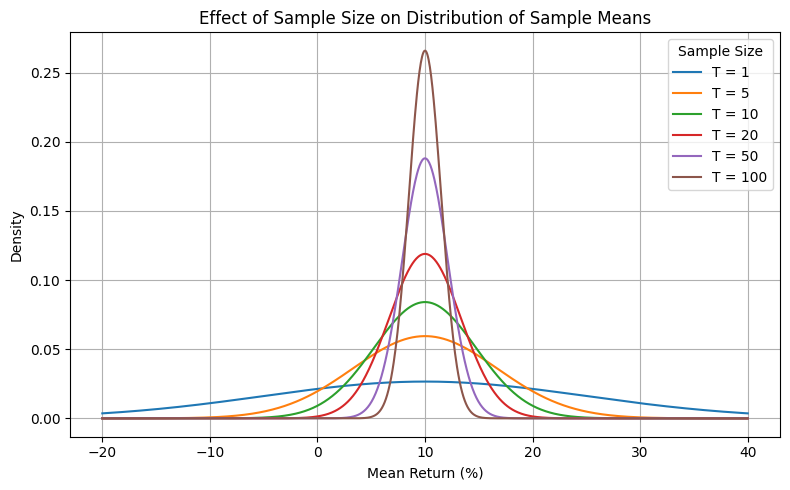

In [ ]:
# Parameters
mu = 10  # Mean return (%)
sigma = 15  # Standard deviation of returns (%)
sample_sizes = [1, 5, 10, 20, 50, 100] # variable T

# Plot
x = np.linspace(-20, 40, 1000)
plt.figure(figsize=(8, 5))
for T in sample_sizes:
    std_error = sigma / np.sqrt(T)
    y = norm.pdf(x, mu, std_error)
    plt.plot(x, y, label=f'T = {T}')

# Formatting
plt.title('Effect of Sample Size on Distribution of Sample Means')
plt.xlabel('Mean Return (%)')
plt.ylabel('Density'); plt.legend(title='Sample Size')
plt.grid(True); plt.tight_layout(); plt.show()

### (Aside) Interpreting Confidence Intervals

Quick distinction between frequentist confidence intervals and Bayesian credible intervals, both often reported in finance.

**Frequentist Confidence Interval**
- *Definition:* If we repeated the experiment many times, the interval would contain the true parameter in 95% of those repetitions (for 5\% significance level).
- The parameter (e.g., true mean return) is fixed (but unknown), while the CI is random because it depends on the sample.
- In the prior graph, “If we repeated the sampling process many times, 95% of the confidence intervals constructed from those samples would contain the true mean return. As sample size grows, the intervals shrink — giving us more precise inference.”

**Bayesian Credible Interval**
- *Definition:* A range of values within which the parameter lies with a certain probability, given the observed data and prior beliefs.
- The parameter is treated as a **random variable** with a probability distribution, while the interval is fixed (function of data and priors)
- “Given the data and prior, there is a 95% probability that the true mean lies between −3% and +23%.” (in-class example)

**Bayesian CIs often more intuitive:**
- **Frequentist:** Like a dartboard — the bullseye (true mean) is fixed, but your darts (sample intervals) scatter. 95% of the time, they’ll land covering the bullseye.
- **Bayesian:** Like a weather forecast — given today’s data and prior knowledge, there’s a 95% chance of rain tomorrow. The probability attaches directly to the event/parameter.

(2) Now, we discuss the impact of **survivorship bias** on our inference of true mean return. Hedge funds have a high failure rate, with approximately 20% of funds closing each year (from class slides). This introduces a bias in our sample, as we only observe the returns of surviving funds, essentially lopping off the left tail of the distribution (see blue curve). This overstates the true mean return, as we are only looking at the winning subset of the population. Per class slides, Cochrane estimates that accounting for this bias decreases mean fund return from 3.12\% to 0.05\%. CRSP as a good example of database that accounts for this bias.

Other biases include:
- **Backfill bias**: Stems from voluntary disclosure of fund performance data, only succeeding funds are include their data.
- **Incubator bias**: Only successful funds launch, but many funds likely fail to launch due to subpar performance in the incubation period. *This implies that even the survivorship bias might be understated.*

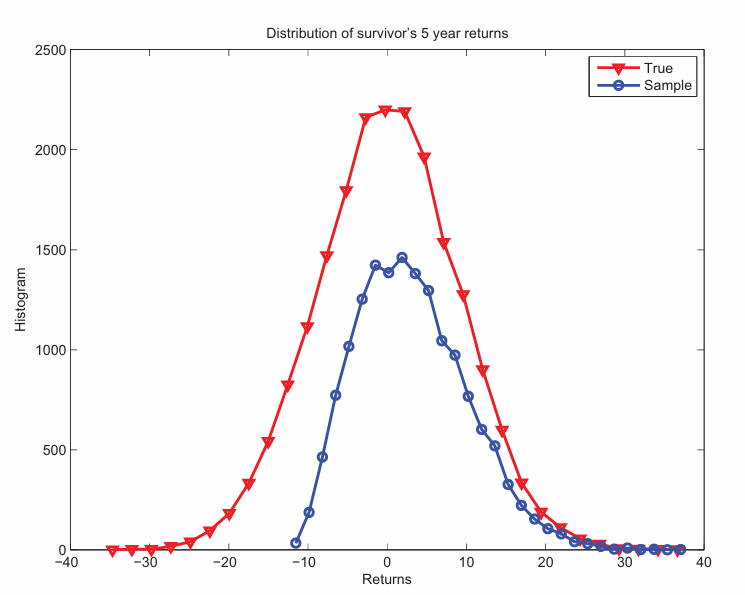

In [ ]:
display(Image(filename="pictures/survivorship_fund_returns.png"))

### 1b. Statistical Uncertainty of Risk-Adjusted Return (Sharpe)

This is a little bit more interesting because now we have uncertainty in both the numerator (mean return) and denominator (volatility). We can approximate the standard error of the Sharpe ratio as (displayed as sample mean, sample standard deviation, and SE of sample SR):

$$\hat{\mu} = \frac{1}{T} \sum_{t=1}^{T} r_t, \quad \hat{\sigma} = \sqrt{\frac{1}{T} \sum_{t=1}^{T} \left(r_t - \hat{\mu}\right)^2}, \quad \text{SE}(\widehat{\text{SR}}) = \sqrt{\frac{1 + \text{SR}^2 / 2}{T}}$$

Note that the sample mean is normally distributed with SE from (1a), the sample standard deviation follows a scaled chi distribution (squared normal), and the Sharpe ratio follows a scaled non-central t-distribution. The delta method gives us a simple approximation for the SE of the Sharpe ratio that is easy to compute and interpret. The following plot shows 95% confidence intervals for an assumed true Sharpe ratio of 1.0 across different sample sizes. Notice how wide the intervals are for small samples, indicating high uncertainty in the estimated Sharpe ratio. Once again, this only holds in the absence of autocorrelation (IID returns).

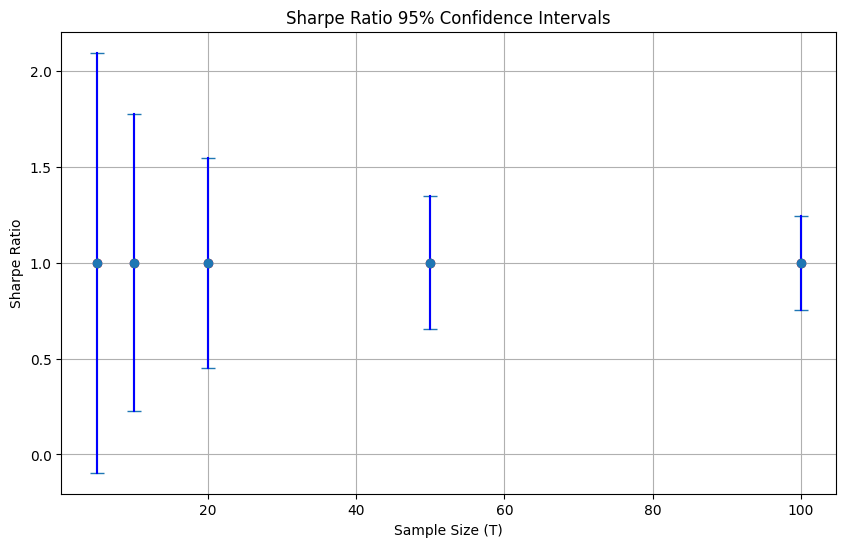

In [ ]:
# Parameters
true_SR = 1.0   # assumed Sharpe Ratio
sample_sizes = [5, 10, 20, 50, 100]  # different horizons

# Compute confidence intervals
lower_bounds = []
upper_bounds = []
for T in sample_sizes:
    SE = np.sqrt((1 + true_SR**2 / 2) / T)
    lower_bounds.append(true_SR - 2 * SE)
    upper_bounds.append(true_SR + 2 * SE)

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, [true_SR]*len(sample_sizes),
             yerr=[np.array(upper_bounds) - true_SR],
             fmt='o', capsize=5, label='95% CI')
for i, T in enumerate(sample_sizes):
    plt.plot([T, T], [lower_bounds[i], upper_bounds[i]], color='blue')
    plt.scatter(T, true_SR, color='red')

# Plot comparison of CIs
plt.title('Sharpe Ratio 95% Confidence Intervals')
plt.xlabel('Sample Size (T)'); plt.ylabel('Sharpe Ratio')
plt.grid(True); plt.show()

### 1c. Does the stationary assumption make sense when evaluating fund performance?

In sections (1a) and (1b), we assume that fund performance/ skill is consistent overtime; equivalently, the mean return is constant through market conditions and employee turnover. We "needed" this assumption to make inferences about **true** fund skill and quantify the uncertainty surrounding our estimates. **Fact: frequentist inference relies on the underlying probabilities being constant (stationary).** I will show that our inferences are even worse than initially suspected if fund skill is nonstationary. Let's bring this to life:

#### (A) Stationary Baseline
- We have an urn of 200 balls divided equally amongst 100 green balls (positive returns) and 100 red balls (negative returns).
- **The proportion of balls is fixed over time (sampling with replacement). Thus P(Green) = 0.5 for all time steps.**
- This urn represents a random walk/ unskilled investor who generates positive returns 50% of the time.
- Our goal is to estimate the proportion of green balls (positive returns) as we draw balls from the urn.

#### (B) Polya's Urn (Non-Stationary)
- Same initial urn of 200 balls (100 green, 100 red).
- Now, we use reinforcement sampling: **each time we draw a ball, we add another ball of the same color to the urn. Thus, the proportion of green balls changes over time based on our draws.**
- In turn, this drops the stationary assumption and introduces path dependence. **Drawing a green ball increases the probability of drawing a green ball in the next draw.**
- **Fact: the limit distribution of the proportion does not converge to a constant, but to a random variable $Z \sim$ Beta(green, red) distribution!**
- Once again, our goal is to estimate the proportion of green balls (positive returns) as we draw balls from the urn. For the frequentists, this is a nightmare since they consider this parameter fixed, but Bayesians can handle this naturally by treating the proportion as a random variable!

Before continuing, let's get a feel for how Polya's urn behaves over time. The graph on the left shows a few paths of the proportion of green balls over time and the plot on the right shows the distribution of the final values. Note:
- The proportion of green balls in the urn after draw $t$ is:
    $$\mathbb{P}(\text{green}) = \frac{(\text{initial green}) + \sum_{i=1}^t X_i}{\text{initial total} + t}$$
  where $X_i$ is an indicator variable for drawing a green ball at time $i$.
- The paths diverge significantly, some converging to high proportions of green balls (skilled investor), while others converge to low proportions (unskilled investor). After $\approx$ 600 draws, the proportion of green balls stabilizes.
- The final proportions (last proportion of each sample path) follow a beta(100, 100) distribution! The average fund manager is unlucky/ unskilled (0.5 mean), but there is significant variation across managers.
- **Analogy: Each positive return (green) makes future positive returns more likely, i.e. success begets success. Early win streaks tilt the urn, making future streaks more likely as early winning managers attract better resources, talent, and capital, endogenously improving "skill". Either way, we want to identify the fund managers with the highest skill/ luck/ propensity to win as measured by the proportion of green balls.**

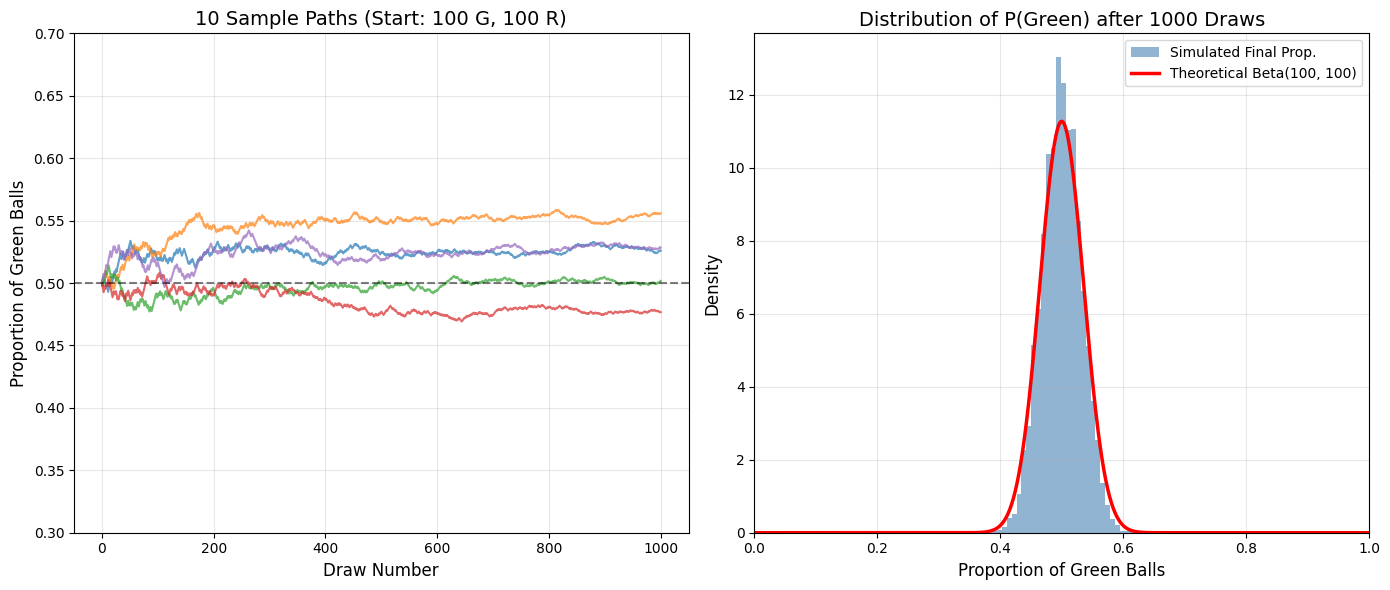

In [ ]:
# Simulation parameters
n_simulations = 10000
n_draws = 1000
g_start = 100
r_start = 100
c = 1  # Number of balls added each draw

# Set initial proportions
# Current counts of green and red for all simulations
proportions = np.zeros((n_simulations, n_draws + 1))
current_g = np.full(n_simulations, g_start)
current_r = np.full(n_simulations, r_start)
proportions[:, 0] = current_g / (current_g + current_r) # Initial proportion

# Run simulation
np.random.seed(42)
for t in range(n_draws):
    prob_g = current_g / (current_g + current_r) # prob of drawing green varies
    draws = np.random.rand(n_simulations) < prob_g # draw ball
    # Update counts
    current_g += draws * c
    current_r += (~draws) * c
    proportions[:, t+1] = current_g / (current_g + current_r)

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# Subplot 1: first few simulations
for i in range(5):
    ax1.plot(range(n_draws + 1), proportions[i, :], alpha=0.7, linewidth=1.5)

ax1.set_title(f'10 Sample Paths (Start: {g_start} G, {r_start} R)', fontsize=14)
ax1.set_xlabel('Draw Number', fontsize=12)
ax1.set_ylabel('Proportion of Green Balls', fontsize=12)
ax1.set_ylim(0.3, 0.7); ax1.grid(True, alpha=0.3); ax1.axhline(0.5, color='black', linestyle='--', alpha=0.5)

# Subplot 2: Distribution of final proportions
final_proportions = proportions[:, -1]
ax2.hist(final_proportions, bins=30, density=True, alpha=0.6, color='steelblue', label='Simulated Final Prop.')
# Overlay Theoretical Beta Distribution
x = np.linspace(0, 1, 1000)
alpha_param = g_start / c
beta_param = r_start / c
y = beta.pdf(x, alpha_param, beta_param)

ax2.plot(x, y, 'r-', linewidth=2.5, label=f'Theoretical Beta({int(alpha_param)}, {int(beta_param)})')
ax2.set_title(f'Distribution of P(Green) after {n_draws} Draws', fontsize=14)
ax2.set_xlabel('Proportion of Green Balls', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)

plt.tight_layout(); plt.show()

**Now, let's make inferences about the proportion of green balls in both systems (i.e. fund manager skill/ luck).** For both the stationary case (left plot) and Polya's urn (right plot), we track (1) the proportion of green balls in the urn and (2) the sample mean (observed proportion of drawn balls).
1. Stationary (left)
    * We assume probability of a good return is 0.5 (=100/200) and sampling does not change the composition. The black dashed line represents the true probability which is constant over time.
    * Every new data point (drawn ball) is an independent "check" against the fixed truth.
    * The sample mean (blue line) converges to the true proportion with precision proportional to the square root of observations. We know that the error asymptotically must go to zero (recall SE formula above).
2. Nonstationary: Polya's Evolution (right)
    * Now, the proportion of green balls is not fixed, but rather **path-dependent**. In relation to fund managers, the skill/ luck/ success of a fund manager evolves over time, before converging to a final state (a random variable with Beta(100,100) distribution).
    * The black line tracks the proportion of green balls. Notice how it drifts over time before converging to a constant (as expected).
    * The sample mean (red line) is based *only* on what we have seen (the draws), ignoring the initial state:
    * Proportion of green balls vs sample mean:
        * You draw 3 Greens in a row
        * Sample Inference: "100% of balls are Green." ($p=1.0$)
        * Actual Truth: "50.7% of balls are Green." ($p=103/203 = 0.507$)
        * Result: You are wrong by ~50%. Your sample is "lying" to you about the population.

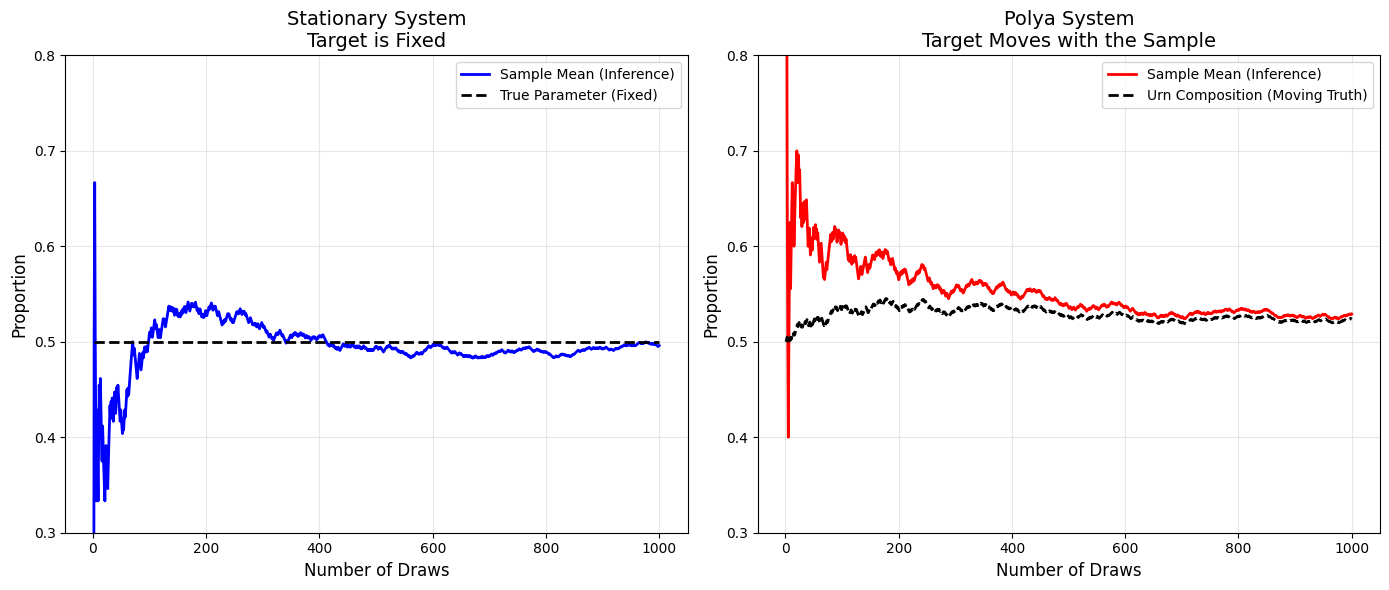

In [ ]:
# Parameters
n_draws = 1000
np.random.seed(16) # Seed chosen for clear visual separation

# --- 1. Stationary System (Coin Flip) ---
true_p_stationary = np.full(n_draws, 0.5) # fixed true parameter
stat_draws = np.random.binomial(1, 0.5, n_draws)
stat_sample_mean = np.cumsum(stat_draws) / np.arange(1, n_draws + 1)

# --- 2. Polya's Urn ---
# Initial urn state, c represents strength of reinforcement
g_start, r_start =100,100
c = 1

g, r = g_start, r_start
polya_urn_comp = []    # The "Truth" (Composition)
polya_draws = []       # The History of Draws

for i in range(n_draws):
    # 1. Record the CURRENT composition
    current_p = g / (g + r)
    polya_urn_comp.append(current_p)

    # 2. Make an Observation
    draw = 1 if np.random.rand() < current_p else 0
    polya_draws.append(draw)

    # 3. Update the composition
    if draw == 1:
        g += c
    else:
        r += c

# Calculate Sample Mean of the draws
polya_draws = np.array(polya_draws)
polya_sample_mean = np.cumsum(polya_draws) / np.arange(1, n_draws + 1)

# --- 3. Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
x_axis = np.arange(1, n_draws + 1)

# Plot 1: Stationary
ax1.plot(x_axis, stat_sample_mean, color='blue', linewidth=2, label='Sample Mean (Inference)')
ax1.plot(x_axis, true_p_stationary, color='black', linestyle='--', linewidth=2, label='True Parameter (Fixed)')
ax1.set_title('Stationary System\nTarget is Fixed', fontsize=14)
ax1.set_xlabel('Number of Draws', fontsize=12)
ax1.set_ylabel('Proportion', fontsize=12)
ax1.set_ylim(0.3, 0.8)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Polya
ax2.plot(x_axis, polya_sample_mean, color='red', linewidth=2, label='Sample Mean (Inference)')
ax2.plot(x_axis, polya_urn_comp, color='black', linestyle='--', linewidth=2, label='Urn Composition (Moving Truth)')
ax2.set_title('Polya System\nTarget Moves with the Sample', fontsize=14)
ax2.set_xlabel('Number of Draws', fontsize=12)
ax2.set_ylabel('Proportion', fontsize=12)
ax2.set_ylim(0.3, 0.8)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 1d. Connection between Polya's Urn and Stochastic Vol/ Interest Rate models

1. Polya's Urn is actually a bad toy example; **inference on the mean is actually easier since the reinforcement mechanism reduces variance over time.**
    1. In the stationary case, each draw is independent, so the sample mean has to average out pure noise and convergence relies on the LLN.
    2. For Polya's urn, the sample mean and urn composition are tightly linked; as the urn composition drifts, the sample mean follows closely. The reinforcement mechanism reduces variance over time, making inference easier. **Its pretty much cheating: we're essentially riding a wave that we are creating.** Note the similarities of the two formulas; as the draws $t$ increase, the initial state is "forgotten":
    - Urn composition after $t$ draws:
     $$\mathbb{P}(\text{green}) = \frac{(\text{initial green}) + \sum_{i=1}^t X_i}{\text{initial total} + t}$$
    - Sample mean after $t$ draws:
     $$\hat{p} = \frac{1}{t} \sum_{i=1}^t X_i$$

However, this intuition is very relevant: nonstationary series require a specified evolution. Estimating a single parameter on drifting data is like chasing a moving Polya target with a stationary estimator; you will severely misprice assets and lose your shirt.

2. Stochastic Volatility in Option Pricing (class recommendation: *Numerical Methods for Option Pricing* with Roger)
    - Black-Scholes assumes constant volatility, but empirical returns show volatility clustering (recall GARCH!) and mean reversion — clearly nonstationary.
    - Like Polya's urn, volatility today depends on past shocks; we can’t just estimate a single $\sigma$
    - Heston model dynamics for volatility (mean-reverting with noise):
        $$d\sigma _t=\kappa (\theta -\sigma _t)dt+\eta dW_t$$

3. Stochastic Interest Rates in Term Structure Models (class recommendation: *Fixed Income Derivatives* with Mark)
    - **Fact: yield curves change over time.**
    - Assuming a constant rate is like assuming a fixed urn — it ignores macro shocks, policy changes, and expectations.
    - Interest rates evolve due to reinforcement (e.g., Fed actions, inflation feedback).
    - Consider interest rate models like Vasicek (mean reversion to long-run average $\beta$:
        $$dr_t=\alpha (\beta -r_t)dt+\sigma dW_t$$

## 2. Measuring Risk

As previewed in week four, determining the price of an illiquid asset is challenging. In this section, we note the implications of hedge funds self-reporting prices for their illiquid assets and how that passes through to fund performance statistics.

First, let's think about how we would determine the price of an illiquid asset. To make this tractable, here's a common question that comes up in investment banking interviews: **How would you value an apple tree (or a house or a company)?**
1. Discounted Cash Flow (DCF) Analysis
    - Estimate how many apples the tree will produce each year, how much each apple can be sold for, subtract costs (watering, pruning, fertilizer), and then discount those future cash flows back to today.
    - Value is based on the present value of expected future cash flows, but unreasonable (from my perspective) since we need assumptions on growth rates and discount rates (which are not easy to predict!).
2. Comparable Company Analysis (Comps)
    - Look at how much similar apple trees are worth in the market. If other orchards are selling trees for \$X per apple produced, you apply that multiple to your tree.
    - Value is relative, based on how similar assets are prices but relies on finding truly comparable “trees” and assumes the market is pricing them fairly (whatever that means).
3. Precedent Transactions Analysis (M&A Comps)
    - Check how much buyers have paid for apple trees in past sales. If someone bought a similar tree for \$Y, that sets a benchmark for your tree’s value.
    - Value is based on historical transaction prices, but past deals may not reflect current conditions/ limited data points

**Of these three approaches, regulatory bodies prefer (1) observable market prices, (2) prices derived from similar assets, and (3) proprietary model-based prices.**
****

For illiquid asset classes, funds will use the last available price (if its favorable) leading to **stale prices** (you bought apples last year, can’t/ don't want to check the market since, so you keep reporting them at last year’s price). Here are some consequences:

1. **Artificial lowering of market risk:** Reported returns look stable, while underlying economic value may be moving more sharply. This inflates fund Sharpe ratios via reducing the volatility (denominator).
2. **Serial autocorrelation** This year's return is highly dependent on last year's return; happens via delayed recognition of shocks: instead of marking a 10\% loss in one month, let's spread it out across three months as -4\%, -3\%, -3\%.
3. **Illusion of diversification:** Illiquid assets may appear uncorrelated with factors and providing diversification benefits, but the time series of returns are not aligned.

*We can check for return smoothing with time series regression of returns on past returns (LFD-style)!* From Asness (2001), via class slides:

$$R^i_t \;=\; \alpha_i \;+\; \beta_{i,0} R^m_t \;+\; \beta_{i,1} R^m_{t-1} \;+\; \beta_{i,2} R^m_{t-2} \;+\; \beta_{i,3} R^m_{t-3} \;+\; \beta_{i,4} R^m_{t-4} \;+\; \epsilon^i_t$$

From the table below, funds are exposed to significant "lagged market risk" (see last column). Must be a coincidence (sarcasm)!

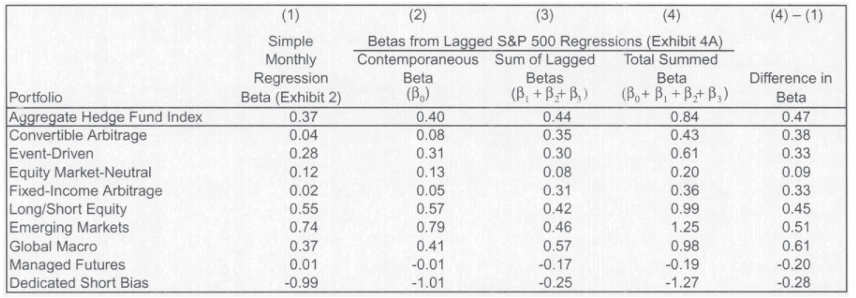

In [ ]:
display(Image(filename="pictures/stale_returns_reg.png"))

**Tail risk** is one of the most important metrics in evaluating fund performance. From an economics perspective, you don't want to lose lots of money via investments in a bad state of the world (economy down, might have lost job) with very high marginal utility of wealth! Mark's Short Term Capital Fund (STCM) is an (imaginary) fund (not advice for a start-up) that sells out-of-the-money (OTM) put options on the S&P 500, collecting small premiums most of the time but suffering catastrophic losses during market crashes. This strategy generates high Sharpe ratios in normal times but exposes investors to significant tail risk. **Equivalent to picking up pennies in front of a steamroller...** Not always a bad strategy, but if you are selling insurance, you should communicate that clearly to investors.

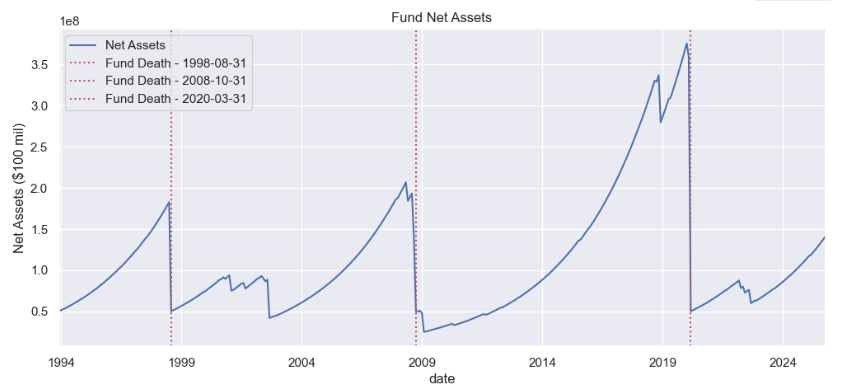

In [ ]:
display(Image(filename="pictures/STCM_AUM.png"))

However, acquiring tail risk is not always as obvious as selling OTM puts. For example, consider merger arbitrage funds that place bets that mergers will succeed (high historical success rate of completed merger conditional on announcement). Here's how it works:
- They buy the target company’s stock (which usually trades slightly below the offer price) and, in stock‑for‑stock deals, short the acquirer’s stock.
- The bet is that once the deal closes, the two stock prices will converge to the agreed exchange ratio or offer price.
- The profit comes from capturing that “spread” between today’s price and the deal price.

**See the Wall Street Journal article below from today (12/5/2025)!**

Let's consider two cases of (1) successful merger and (2) failed merger.
- Completed merger:
    - Company A agrees to buy Company B for \$50 per share.
    - Company B’s stock trades at \$47 (reflecting deal risk, never converges to deal price before close).
    - The arbitrageur buys at \\$47, expecting to get \\$50 when the deal closes.
    - If the merger succeeds, they pocket the \$3 difference.
- Failed merger
    - Same setup: Company A offers \$50 for Company B.
    - Arbitrageur buys Company B at \$47.
    - Regulators block the deal or financing collapses.
    - Company B’s stock crashes back to \$35, and Company A’s stock jumps.
    - The arbitrageur is “left holding the bag” — losing money on both sides of the trade.

We can detect tail risk in returns sequences by using LFDs as seen in HW8 (Treynor-Mazuy (quadratic), piecewise regression). As Nassim Taleb points out, we cannot infer the probability of rare, high‑impact events (Black Swans) from past observations if those events have never been seen.

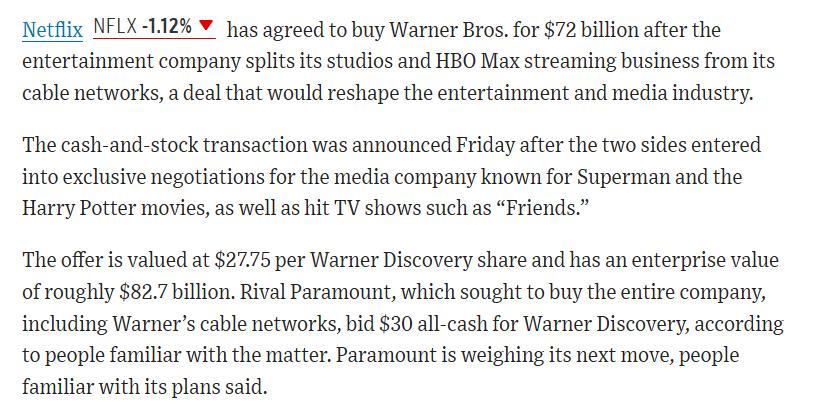

In [ ]:
# Today's top WSJ headline
display(Image(filename="pictures/NTFLX_arb.png"))

## 3. Manager Incentives

Historically, hedge fund fee structures have been 2\% of AUM plus 20\% of profits. As shown below, this fee structure resembles a call option payoff, where the fund manager earns a fixed fee (2\% of AUM) regardless of performance, plus a variable fee (20\% of profits) that kicks in only when the fund generates positive returns. This creates an incentive for managers to take on riskier strategies to achieve higher profits, as they benefit from upside while being protected from downside (limited to the fixed fee).

From the perspective of Black-Scholes, increased volatility on the underlying increases option value (higher probability of ending up significantly ITM with none of the downside risk). **In our case, the underlying is PnL, so managers are incentivized to pursue more volatile strategies.**

\begin{align*}
    C &= S_0 N(d_1) - K e^{-rT} N(d_2)\\
    d_1 &= \frac{\ln(\frac{S_0}{K}) + (r + \frac{\textcolor{green}{\sigma}^2}{2})T}{\textcolor{green}{\sigma} \sqrt{T}}\\
    d_2 &= d_1 - \textcolor{green}{\sigma} \sqrt{T}\\
    \frac{\partial C}{\partial \sigma }&=S_0\cdot \sqrt{T}\cdot \phi (d_1) \geq 0 \tag{Vega}
\end{align*}
where $\phi(d_1) > 0$ represents the height of the standard normal density function at $d_1$.

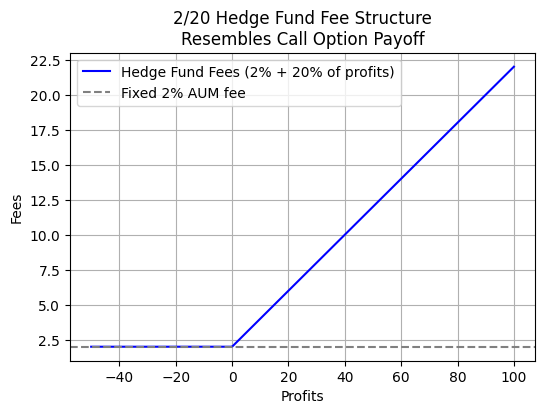

In [ ]:
# Parameters
AUM = 100  # Assets under management (for scaling the 2% fee)
management_fee = 0.02 * AUM  # 2% of AUM
profit_range = np.linspace(-50, 100, 300)  # Possible profits

# Fee structure: 2% of AUM + 20% of profits (only if profits > 0)
fees = management_fee + np.where(profit_range > 0, 0.20 * profit_range, 0)

# Plot
plt.figure(figsize=(6,4))
plt.plot(profit_range, fees, label="Hedge Fund Fees (2% + 20% of profits)", color="blue")
plt.axhline(management_fee, linestyle="--", color="gray", label="Fixed 2% AUM fee")
plt.xlabel("Profits"); plt.ylabel("Fees")
plt.title("2/20 Hedge Fund Fee Structure\nResembles Call Option Payoff")
plt.legend(); plt.grid(True); plt.show()

## 4. Thank you!

Congrats on almost finishing the course! This quarter is by far the busiest between internship applications, tough courses, and adjusting to new routines. In the following quarters, the cohort will follow separate tracks, you will pursue classes that better align with your interests and career goals. Feel free to connect on LinkedIn and keep me updated, rooting for you all.